## Part 1: Importing libraries


In [87]:
# General
import pandas as pd # dataframe
import numpy as np # vector calcs
import json # loading json
from pprint import pprint # previewing json
import re # data pre-processing
import matplotlib.pyplot as plt # plots
%matplotlib inline
plt.style.use('ggplot')
from sklearn.manifold import TSNE
from tqdm import tqdm

# Text transformation 
import nltk 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
import string
from nltk.stem import PorterStemmer
import collections
import nltk.classify.util, nltk.metrics
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('wordnet')

# Modelling and evaluation
from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn import svm
from sklearn.model_selection import cross_val_score

import keras
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation, Input
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras import layers
from sklearn.model_selection import StratifiedKFold
from tensorflow import set_random_seed

# Label Encoder
from sklearn.preprocessing import LabelEncoder

## Plotly
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

[nltk_data] Error loading wordnet: <urlopen error Tunnel connection
[nltk_data]     failed: 407 Proxy Authentication Required>
C:\Users\JANOWSM\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.



## Part 2: Loading the json files
1. Loading three separate json files from the directory
2. Loading files in pandas DataFrame
3. Union 3 files into one file called "data"

In [88]:
data_racism = pd.read_json("racism.json", lines=True)
data_sexism = pd.read_json("sexism.json", lines=True)
data_neither = pd.read_json("neither.json", lines=True)


data_r_s = data_racism[["Annotation", "favorite_count", "favorited", "retweet_count", "retweeted", "text"]]
data_s_s = data_sexism[["Annotation", "favorite_count", "favorited", "retweet_count", "retweeted", "text"]]
data_n_s = data_neither[["Annotation", "favorite_count", "favorited", "retweet_count", "retweeted", "text"]]
data = pd.concat([data_r_s, data_s_s, data_n_s], ignore_index=True)

data = data.sort_values("Annotation", ascending = True)

In [89]:
data.head()

,Annotation,favorite_count,favorited,retweet_count,retweeted,text
8453,none,1,False,0,False,"If Sheri and Emilie go home, im not watching t..."
11262,none,0,False,0,False,@mattstratton @Magnus919 @theckman @cheeseplus...
11263,none,13,False,0,False,Forever entertained by the 'clink' noises my l...
11264,none,0,False,0,False,@_peech @StarKat99 @therealroseanne holy shit.
11265,none,0,False,59,False,RT @_peech: How @therealroseanne sees trans pp...


## Part 3: Pre-processing tweets
My baseline model is going to be SVM model based on the pre outome of text TF-IDF transformation. The text transformation will include:

1. Clean data: emojis, url, @, numbers, hashtags etc.
2. Replace user names and urls with tags, 
3. Normalising to lower_case
4. Tokenize
5. Remove punctuation
6. Remove StopWords
7. Remove numeric

My chosen models in the second part is are be Word2Tex and FastText (in Gensim implementation). Those two models are more sensitive to the contextual differences for a word or n-gram and therefore the text is only lightly pre-processed, leaving in punctuation, stopwords etc.

## Part 3a: Pre-processing tweets for vectorizers: TF-IDF

In [90]:
# defining the emojis string for the regex pattern

emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
        
    )"""

# defining the letters and numbers string for the regex pattern inc emojis, ensuring that #NLP stays as one word in tokenization 
# and not is split into "#" and "NLP"

regex_str = [
    emoticons_str,
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs


    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
]

# Compiling all patterns together
tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)
  

def preprocess_baseline_models(text):
    text = re.sub(r"@\w+", "<user>", text) # @ replaced
    text = re.sub(r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', "<url>", text)
    # Remove whitespace (including new line characters)
    text = re.sub(r'\s\s+', ' ', text)
    # Remove single space remaining at the front of the tweet.
    text = text.lstrip(' ')  
    text = text.lower()
    s = text.replace('&', ' and ')
    s = s.replace('@', ' at ')
    s = s.replace('0', ' zero ')
    s = s.replace('1', ' one ')
    s = s.replace('2', ' two ')
    s = s.replace('3', ' three ')
    s = s.replace('4', ' four ')
    s = s.replace('5', ' five ')
    s = s.replace('6', ' six ')
    s = s.replace('7', ' seven ')
    s = s.replace('8', ' eight ')
    s = s.replace('9', ' nine ')
    tokenized_words = tokens_re.findall(s)
    remove = ['rt', '<user>', '<url>', 'RT']
    tokenized_words = [w for w in tokenized_words if w not in remove]
    tokenized_words = [nltk.stem.WordNetLemmatizer().lemmatize(w) for w in tokenized_words]
    tokenized_words = [nltk.stem.porter.PorterStemmer().stem(w) for w in tokenized_words]
    #import string
    table = str.maketrans('', '', string.punctuation)
    tokenized_words = [word.translate(table) for word in tokenized_words]
    tokenized_words = [word for word in tokenized_words if word not in stopwords.words('english')]
    tokenized_words = [word for word in tokenized_words if word.isalpha()]
    return tokenized_words    
    
def preprocess_baseline_models_stem(tokenized_words):
    #tokenized_words = [word for word in tokenized_words if word not in stopwords.words('english')]
    tokenized_words = [nltk.stem.WordNetLemmatizer().lemmatize(w) for w in tokenized_words]
    tokenized_words = [nltk.stem.porter.PorterStemmer().stem(w) for w in tokenized_words]
    return tokenized_words


## Part 3b: Pre-processing tweets for text transformation with  FastText

In [91]:
def preprocess_w2v_ft(text):
    text = re.sub(r"@\w+", "<user>", text) # @ replaced
    text = re.sub(r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', "<url>", text)
    text = text.replace("#", "")
    text = text.replace('"', "")
    text = text.replace("'", "")
    # Remove whitespace (including new line characters)
    text = re.sub(r'\s\s+', ' ', text)
    # Remove single space remaining at the front of the tweet.
    text = text.lstrip(' ')  
    text = text.lower()
    s = text.replace('&', ' and ')
    s = s.replace('@', ' at ')
    s = s.replace('0', ' zero ')
    s = s.replace('1', ' one ')
    s = s.replace('2', ' two ')
    s = s.replace('3', ' three ')
    s = s.replace('4', ' four ')
    s = s.replace('5', ' five ')
    s = s.replace('6', ' six ')
    s = s.replace('7', ' seven ')
    s = s.replace('8', ' eight ')
    s = s.replace('9', ' nine ')
    tokenized_words = tokens_re.findall(s)
    remove = ['rt', '<user>', '<url>', 'RT']
    tokenized_words = [w for w in tokenized_words if w not in remove]
    return tokenized_words

## Part 4: Creating text processed columns
1. tweets_words: baseline models
3. tweets_sent: deep learning models

In [95]:
data["tweets_words"] = data["text"].apply(preprocess_baseline_models)

In [93]:
data["tweets_sent"] = data["text"].apply(preprocess_w2v_ft)

In [94]:
data = data.reset_index()
data[:3]

,index,Annotation,favorite_count,favorited,retweet_count,retweeted,text,tweets_words,tweets_sent
0,8453,none,1,False,0,False,"If Sheri and Emilie go home, im not watching t...","[sheri, emili, go, home, im, watch, show, anym...","[if, sheri, and, emilie, go, home, ,, im, not,..."
1,11262,none,0,False,0,False,@mattstratton @Magnus919 @theckman @cheeseplus...,"[talk, bring, tweet, back, dead]","[talk, about, bringing, tweets, back, from, th..."
2,11263,none,13,False,0,False,Forever entertained by the 'clink' noises my l...,"[forev, entertain, clink, nois, lip, pierc, ma...","[forever, entertained, by, the, clink, noises,..."


## Part 5: Adding count of words / distinct count of words / average words length to dataframe

In [96]:
# get a word count per sentence column

def word_count(text):
    # Find the total number of words in the tweet
    total_words = len(text)
    
    # Return the word counts
    return total_words

def distinct_word_count(text):
    
    # Find the total number of DISTINCT words in the tweet
    total_distinct_words = len(set(w for w in text))
    
    return total_distinct_words

def avg_word_len(text):
    
    avg_word_len = np.mean([len(w) for w in text ])
    if np.isnan(avg_word_len):
        avg_word_len = 0
    else:
        avg_word_len = avg_word_len
    
    return avg_word_len 

In [97]:
data['avg_word_len'] = data['tweets_words'].apply(avg_word_len)
data['word count'] = data['tweets_words'].apply(word_count)
data['distinct word count'] = data['tweets_words'].apply(distinct_word_count)
data[:5]

C:\Users\JANOWSM\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning:

Mean of empty slice.



,index,Annotation,favorite_count,favorited,retweet_count,retweeted,text,tweets_words,tweets_sent,avg_word_len,word count,distinct word count
0,8453,none,1,False,0,False,"If Sheri and Emilie go home, im not watching t...","[sheri, emili, go, home, im, watch, show, anym...","[if, sheri, and, emilie, go, home, ,, im, not,...",4.0,9,9
1,11262,none,0,False,0,False,@mattstratton @Magnus919 @theckman @cheeseplus...,"[talk, bring, tweet, back, dead]","[talk, about, bringing, tweets, back, from, th...",4.4,5,5
2,11263,none,13,False,0,False,Forever entertained by the 'clink' noises my l...,"[forev, entertain, clink, nois, lip, pierc, ma...","[forever, entertained, by, the, clink, noises,...",4.6,15,15
3,11264,none,0,False,0,False,@_peech @StarKat99 @therealroseanne holy shit.,"[holi, shit]","[holy, shit, .]",4.0,2,2
4,11265,none,0,False,59,False,RT @_peech: How @therealroseanne sees trans pp...,"[see, tran, ppl, sex, worker, nice, femin, u, ...","[:, how, sees, trans, ppl, and, sex, workers, ...",3.6,10,10


## Part 6: Splitting the data for the predictive model into train and test parts

In [98]:
# Create a series to store the labels: y
y = data[["Annotation"]]

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(data[["tweets_words", "tweets_sent", "text", 'avg_word_len','word count','distinct word count' , 'favorite_count','retweet_count']], y, test_size = 0.33, random_state = 53)

In [99]:
# Creating train set

train_data = pd.merge(X_train, y_train, left_index=True, right_index=True).reset_index()

In [100]:
# Creating test set

test_data = pd.merge(X_test, y_test, left_index=True, right_index=True).reset_index()

## Part 7: EDA (Train data only)

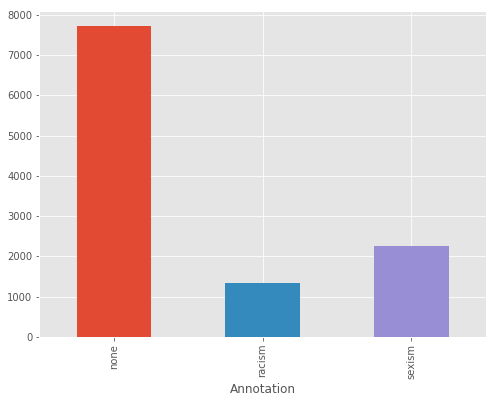

In [101]:
# there is an imbalance among the 3 classes in the data
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
train_data.groupby('Annotation').Annotation.count().plot.bar(ylim=0)
plt.show()

1. Number of tweets by content class

In [102]:
print(train_data["Annotation"].value_counts())
print(data.shape[0])
# do a format thing

none      7720
sexism    2265
racism    1342
Name: Annotation, dtype: int64
16907


In [103]:
data_r_s = train_data[train_data["Annotation"]=="racism"]
data_s_s = train_data[train_data["Annotation"]=="sexism"]
data_n_s = train_data[train_data["Annotation"]=="none"]

2. Summary stats for the dataset by the content class with histograms

Metric: avg_word_len Annotation
none      4.621412
racism    5.202047
sexism    4.804475
Name: avg_word_len, dtype: float64


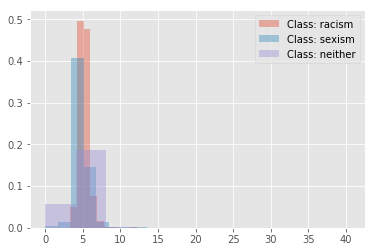

Metric: word count Annotation
none      8.023998
racism    9.335526
sexism    9.127405
Name: word count, dtype: float64


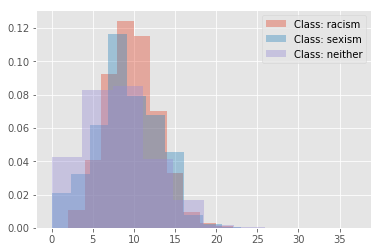

Metric: distinct word count Annotation
none      7.729241
racism    8.887652
sexism    8.787464
Name: distinct word count, dtype: float64


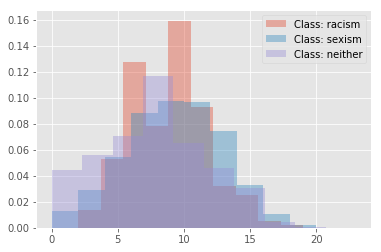

Metric: favorite_count Annotation
none      3.190853
racism    0.081478
sexism    0.839359
Name: favorite_count, dtype: float64


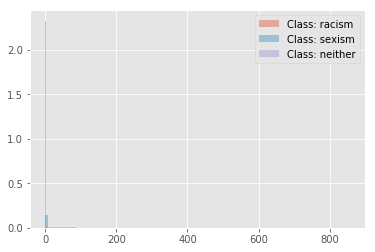

Metric: retweet_count Annotation
none      30.114773
racism    12.224696
sexism    20.330612
Name: retweet_count, dtype: float64


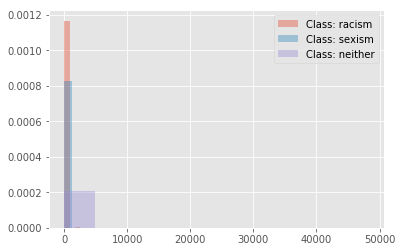

In [104]:
metric_list = ["avg_word_len", 'word count', 'distinct word count', "favorite_count", "retweet_count"]

for i in metric_list:
    print("Metric:", i, data.groupby("Annotation")[i].mean())
    plt.hist(data_r_s[i], alpha =0.4, density = True, label = "Class: racism")
    plt.hist(data_s_s[i], alpha =0.4, density = True, label = "Class: sexism")
    plt.hist(data_n_s[i], alpha =0.4, density = True, label = "Class: neither")
    plt.legend()
    plt.show()
    
# The distribution of various metrics for 3 datasets appear to be similar for sexist and neutral tweets but 
# slightly different for racist tweets

## Part 8: Frequency distribution words
1. Words FreqDist for the whole dataset
2. Words FreqDist by class content

Most frequent words for all data : [('mkr', 3541), ('one', 1268), ('thi', 1017), ('zero', 993), ('im', 932), ('woman', 778), ('sexist', 743), ('two', 724), ('islam', 717), ('kat', 715), ('like', 709), ('wa', 634), ('dont', 605), ('go', 568), ('muslim', 537), ('get', 534), ('peopl', 483), ('amp', 480), ('five', 433), ('think', 416)]


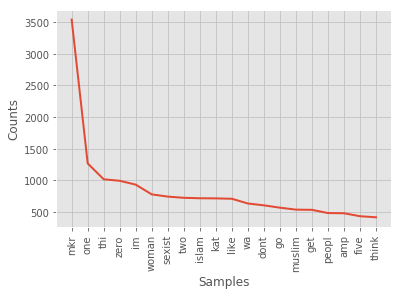

Most frequent words for dataset with racism content : [('islam', 505), ('muslim', 413), ('zero', 249), ('one', 182), ('murder', 148), ('moham', 117), ('wa', 109), ('religion', 105), ('isi', 99), ('jew', 93), ('peopl', 92), ('quran', 86), ('woman', 82), ('like', 79), ('prophet', 78), ('year', 74), ('ha', 71), ('four', 70), ('becaus', 68), ('christian', 66)]


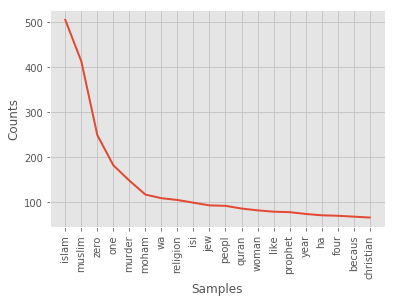

Most frequent words for dataset with sexist content : [('mkr', 693), ('sexist', 653), ('im', 481), ('woman', 446), ('girl', 267), ('kat', 233), ('one', 205), ('dont', 174), ('like', 173), ('call', 167), ('two', 165), ('femal', 157), ('thi', 155), ('men', 154), ('notsexist', 137), ('zero', 133), ('think', 126), ('cant', 116), ('get', 111), ('feminist', 101)]


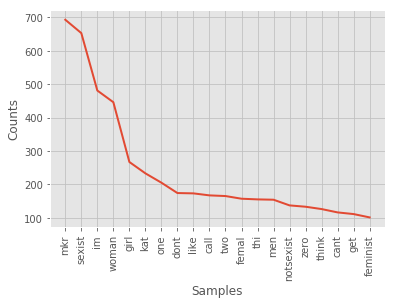

Most frequent words for dataset with neutral content (only) : [('mkr', 2842), ('one', 881), ('thi', 801), ('zero', 611), ('two', 509), ('kat', 482), ('like', 457), ('im', 439), ('go', 432), ('wa', 425), ('get', 385), ('amp', 380), ('dont', 378), ('five', 337), ('peopl', 331), ('andr', 318), ('three', 271), ('make', 267), ('think', 257), ('woman', 250)]


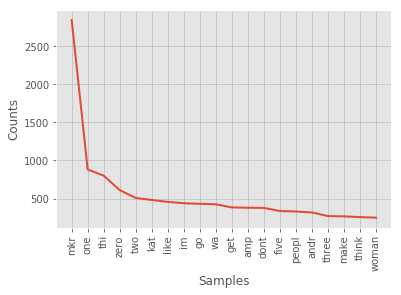

In [105]:
# to create the FreqDist for a dataset I create a flat list from list of lists

dataset_list = [train_data, data_r_s, data_s_s, data_n_s]
dataset_name = ["all data", "dataset with racism content", "dataset with sexist content", "dataset with neutral content (only)"]

for count, i in enumerate(dataset_list):
    flat_list_all = [item for sublist in i['tweets_words'] for item in sublist]
    # Construct a frequency distribution over the lowercased words in the document
    fd_words = nltk.FreqDist(w.lower() for w in flat_list_all)
    # Find the top 20 most frequently used words in the speech
    print("Most frequent words for", dataset_name[count], ":", fd_words.most_common(20))
    fd_words.plot(20)

## Part 9 Baseline Modelling
1. TF-IDF Vectorizer + SVM

For each model the grid search and k-fold validation is performed before testing model

## Encoding label to comply with the label format requirement

0 - none |
1 - racist |
2 - sexist

In [106]:
# Encoding labels for baseline model
# train data
label_encoder = LabelEncoder()
label_encoder.fit(train_data.Annotation)
train_data['Annotation'] = label_encoder.transform(train_data.Annotation)

# test data
label_encoder = LabelEncoder()
label_encoder.fit(test_data.Annotation)
test_data['Annotation'] = label_encoder.transform(test_data.Annotation)

# tansform format of labels for SVM
y_train_1d = train_data["Annotation"].ravel()
y_test_1d = test_data["Annotation"].ravel()


## TF-IDF

In [107]:
# max_df - ignore terms that appear in more than 70% of the tweets
# min_df - ignore terms that appear in less than 3 times the tweets
# ngram_range -ngram range between 1 and 4

tfidf_vectorizer = TfidfVectorizer(analyzer = preprocess_baseline_models, max_df=0.7, min_df = 3, ngram_range = (1,4))

# Transform the train data: tfidf_train
tfidf_train = tfidf_vectorizer.fit_transform(train_data["text"])
print (tfidf_train.shape)

# Transform the test data: tfidf_test 
tfidf_test = tfidf_vectorizer.transform(test_data["text"])

(11327, 3625)


In [108]:
# Print the first 10 features
print(tfidf_vectorizer.get_feature_names()[:10])

['abduct', 'abil', 'abl', 'abnorm', 'abort', 'abov', 'absolut', 'absurd', 'abt', 'abu']


## TF-IDF + SVM

1. Support Vector Machine algorithm to produce the decision boundary between the text classes. 
2. The algorithm maximises the distance of the class to boundary hyperplane (or line in case of 2d problems). 
3. Using linear kernel to prevent model overfitting

In [109]:
# set seed

np.random.seed(42)

In [110]:
#C=1.0
# SVC with linear kernel
svc = svm.SVC(kernel='linear', class_weight = "balanced")
svc.get_params()

{'C': 1.0,
 'cache_size': 200,
 'class_weight': 'balanced',
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'auto',
 'kernel': 'linear',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [111]:
# Define a grid of hyperparameter 'params_svc'
params_svc = {"C" : [ 0.19, 0.20, 0.21]}

In [112]:
from sklearn.model_selection import GridSearchCV
# Instantiate 'grid_rf'
grid_svc = GridSearchCV(estimator=svc,
                               param_grid=params_svc, 
                               cv=5,
                               scoring='accuracy',
                               verbose=1,
                               n_jobs=-1 
                               
                              )

In [113]:
# Fit 'grid_rf' to the training set
grid_svc.fit(tfidf_train, y_train_1d)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.6min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [0.19, 0.2, 0.21]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='accuracy',
       verbose=1)

In [114]:
# Extract best hyperparameters from 'grid_rf'
best_hyperparams = grid_svc.best_params_

print('Best hyperparameters:\n', best_hyperparams)

# Extract best model from 'grid_svc'
best_model = grid_svc.best_estimator_
#print('Best hyperparameters score: {:.4f} '.format(grid_svc.best_score_))

# cross-validate the model on train data
cv_results = cross_val_score(best_model, tfidf_train, y_train_1d, cv=5) # returns of array of cross-validation scores
#print('Best hyperparameters:\n',cv_results) # the array len == cv (the array represents R2)
print("Training Accuracy (cross validation): {:.4f} ".format(cv_results.mean()))
#print(cv_results.std())

Best hyperparameters:
 {'C': 0.2}
Best hyperparameters score: 0.8147 
Training Accuracy (cross validation): 0.8147 


In [115]:
y_pred = best_model.predict(tfidf_test)
print("Testing Accuracy: {:.4f}".format(metrics.accuracy_score(y_test_1d, y_pred)))
print (classification_report(y_pred,y_test_1d))

Testing Accuracy: 0.8147
             precision    recall  f1-score   support

          0       0.86      0.87      0.86      3764
          1       0.85      0.68      0.76       786
          2       0.64      0.73      0.68      1030

avg / total       0.82      0.81      0.82      5580



## Part 10 Word-vector Modelling

1. FastText model (Gensim implementation)
2. This is a simple model that only use the FastText vectors to predict the class of the tweet. The word vector dimension is set to 200 and it looks at the context of 5 words enriched with word ngrams

In [121]:
from gensim.models.fasttext import FastText

# Set values for various parameters
num_features = 200   # Word vector dimensionality  
context = 5          # Context window size                                                                                    
min_word_count = 3   # Minimum word count                        
downsampling = 1e-3   # Downsample setting for frequent words
min_n = 3
max_n = 6



model = FastText(train_data["tweets_sent"], 
                    size=num_features, 
                    window=context, 
                    min_count=min_word_count,
                    sample=downsampling, 
                    sg=1, 
                    iter=50,
                   hs = 0,
                   negative = 10,
                min_n = 3,
                max_n = 6,
                word_ngrams = 1,
                )

In [122]:
# in dictionary every word exists only once
word_vectors = model.wv
print("Number of word vectors: {}".format(len(word_vectors.vocab)))

Number of word vectors: 4758


## Checking the similar words for the model validity

In [123]:
# finding opposites
model.wv.most_similar_cosmul(positive=['woman', 'male'], negative=['man'])

[('female', 0.9228426814079285),
 ('all-female', 0.8378647565841675),
 ('scale', 0.8286566138267517),
 ('comfortable', 0.8265814185142517),
 ('felt', 0.8150038123130798),
 ('uncomfortable', 0.8131420016288757),
 ('verified', 0.8128242492675781),
 ('style', 0.8030083179473877),
 ('womans', 0.7942230105400085),
 ('dumbass', 0.7923799157142639)]

## Format the data to create the featureVec

1. Defining the function for the text input that will create the average of the word vector called feature vector
2. Input into DataFrames: train_data and test_data

In [124]:
def get_feature_vector_ft(data_column):
    index2word_set = set(model.wv.vocab.keys())  # words known to model
    featureVec = np.zeros(model.vector_size, dtype="float32")
    featureVec 
    #     # Initialize a counter for number of words in a review
    nwords = 0
    #     # Loop over each word in the comment and, if it is in the model's vocabulary, add its feature vector to the total
    for word in data_column:
        if word in index2word_set: 
            featureVec = np.add(featureVec, model[word])
            nwords += 1.

    #     # Divide the result by the number of words to get the average
    if nwords > 0:
        featureVec = np.divide(featureVec, nwords)
    #print(featureVec)
    return featureVec
#train_data["tweets_sent"]

In [125]:
train_data["feature_vec_ft_soft_clean"] =train_data["tweets_sent"].apply(get_feature_vector_ft)
X_train_ft_soft_clean = np.array(list(map(np.array, train_data.feature_vec_ft_soft_clean)))

C:\Users\JANOWSM\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



In [126]:
test_data["feature_vec_ft_soft_clean"] =test_data["tweets_sent"].apply(get_feature_vector_ft)
X_test_ft_soft_clean = np.array(list(map(np.array, test_data.feature_vec_ft_soft_clean)))

C:\Users\JANOWSM\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



In [127]:
print(train_data["feature_vec_ft_soft_clean"].shape)
print(len(y_train_1d))

(11327,)
11327


In [128]:
print(test_data["feature_vec_ft_soft_clean"].shape)
print(len(y_test_1d))

(5580,)
5580


## FastText Word2Vec + SVM

In [152]:
#C=1.0
# SVC with linear kernel
svc = svm.SVC(kernel='linear', class_weight = "balanced")
#svc.get_params()

{'C': 1.0,
 'cache_size': 200,
 'class_weight': 'balanced',
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'auto',
 'kernel': 'linear',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [153]:
# Define a grid of hyperparameter 'params_svc'
params_svc = {"C" : [ 0.007, 0.008, 0.009]}

In [154]:
from sklearn.model_selection import GridSearchCV
# Instantiate 'grid_rf'
grid_svc = GridSearchCV(estimator=svc,
                               param_grid=params_svc, 
                               cv=5,
                               scoring='accuracy',
                               verbose=1,
                               n_jobs=-1 
                               
                              )

In [155]:
# Fit 'grid_rf' to the training set
grid_svc.fit(X_train_ft_soft_clean, y_train_1d)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  6.6min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [0.007, 0.008, 0.009]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='accuracy',
       verbose=1)

In [163]:
# Extract best hyperparameters from 'grid_rf'
best_hyperparams = grid_svc.best_params_

print('Best hyperparameters:\n', best_hyperparams)

# Extract best model from 'grid_svc'
best_model = grid_svc.best_estimator_
#print('Best hyperparameters score: {:.4f} '.format(grid_svc.best_score_))

# cross-validate the model on train data
cv_results = cross_val_score(best_model, X_train_ft_soft_clean, y_train_1d, cv=5) # returns of array of cross-validation scores
#print('Best hyperparameters:\n',cv_results) # the array len == cv (the array represents R2)
print("Training Accuracy (cross validation): {:.4f} ".format(cv_results.mean()))
#print(cv_results.std())

Best hyperparameters:
 {'C': 0.009}
Best hyperparameters score: 0.7331 
Training Accuracy (cross validation): 0.7331 


In [164]:
y_pred = best_model.predict(X_test_ft_soft_clean)
print("Testing Accuracy: {:.4f}".format(metrics.accuracy_score(y_test_1d, y_pred)))
print (classification_report(y_pred,y_test_1d))

Testing Accuracy: 0.7280
             precision    recall  f1-score   support

          0       0.75      0.84      0.79      3352
          1       0.89      0.50      0.64      1118
          2       0.58      0.61      0.59      1110

avg / total       0.74      0.73      0.72      5580



## Part 11:  Deep Learning Modelling

## Counting number of tokens

In [165]:
from collections import Counter

list_sentences_train_counter = [item for sublist in train_data["tweets_sent"] for item in sublist]
list_sentences_test_counter = [item for sublist in test_data["tweets_sent"] for item in sublist]

vocab = Counter(list_sentences_train_counter)

#+list_sentences_test_counter
print("The train data vocabulary contains {} unique tokens".format(len(vocab)))

The train data vocabulary contains 13538 unique tokens


## Formatting the text to list of lists

In [166]:
list_sentences_train = list(train_data["tweets_sent"].fillna("NAN_WORD").values)
list_sentences_test = list(test_data["tweets_sent"].fillna("NAN_WORD").values)
#tokenizer = WordPunctTokenizer()
def process_tweets(list_sentences, lower=False):
    tweets = []
    for text in tqdm(list_sentences):
        txt = text
        tweets.append(txt)
    return tweets

tweets = process_tweets(list_sentences_train+list_sentences_test)
#comments

100%|████████████████████████████████████████████████████████████████████████| 16907/16907 [00:00<00:00, 574013.86it/s]


## Parameters for Keras models

In [167]:
# MAX_NB_WORDS - the number of words in the dictionary
# MAX_SEQUENCE_LENGTH - the maximum number of the word sequence


MAX_NB_WORDS = len(word_vectors.vocab) 
MAX_SEQUENCE_LENGTH = 200 
embedding_dim = 200

WV_DIM = 200
nb_words = len(vocab)

word_index = {t[0]: i+1 for i,t in enumerate(vocab.most_common(MAX_NB_WORDS))}

In [168]:
# creating the "word index" for each item in each tweet
sequences = [[word_index.get(t, 0) for t in tweet]
             for tweet in tweets[:len(list_sentences_train)]]
test_sequences = [[word_index.get(t, 0)  for t in tweet] 
                  for tweet in tweets[len(list_sentences_train):]]


In [169]:
print("Example word in tweets:",tweets[0][5])
print("The positon (word_index) of the word: {}".format(word_index.get(tweets[0][5])))

Example word in tweets: chair
The positon (word_index) of the word: 3732


In [170]:
# pad sequence with 0 to the number of MAX_SEQUENCE-lENGTH

X_train = pad_sequences(sequences, padding='post', maxlen=MAX_SEQUENCE_LENGTH)
X_test = pad_sequences(test_sequences, padding='post', maxlen=MAX_SEQUENCE_LENGTH)

In [171]:
# transofrm labels for deep learning model (change y labels for compatibility with multiclass scoring "accuracy" metric)

# Convert labels to categorical one-hot encoding
y_train_one_hot = keras.utils.to_categorical(y_train_1d, num_classes=3)
y_test_one_hot = keras.utils.to_categorical(y_test_1d, num_classes=3)

In [172]:
# imbalanced class dictionary

class_weights = {}
class_weights[0] = np.where(y_test_1d == 0)[0].shape[0]/float(len(y_test_1d))
class_weights[1] = np.where(y_test_1d == 1)[0].shape[0]/float(len(y_test_1d))
class_weights[2] = np.where(y_test_1d == 2)[0].shape[0]/float(len(y_test_1d))

In [173]:
# defining function for epoch vizualisation and finding best model hyperparameters



def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

## Deep Learning Model 1 (Keras implementation)

1. Layers: Sequential
2. Random Embedding

acc: 79.30%


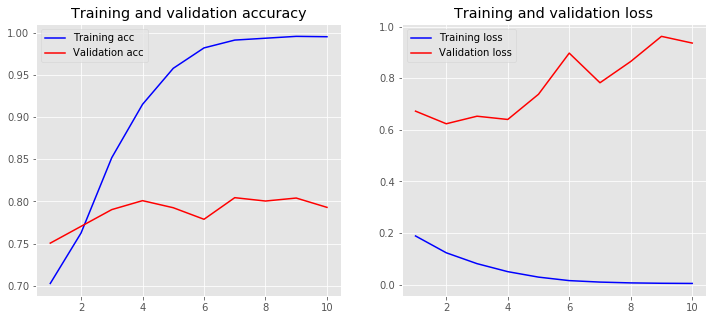

acc: 79.79%


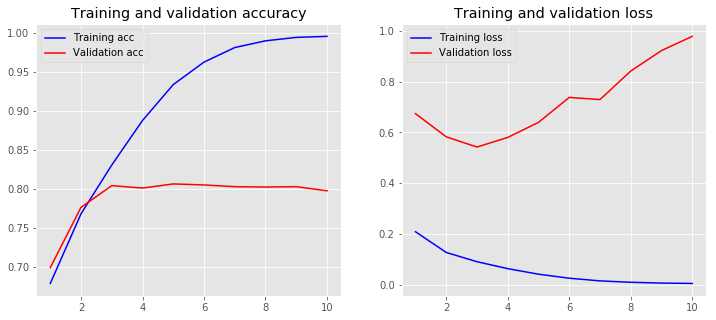

acc: 82.12%


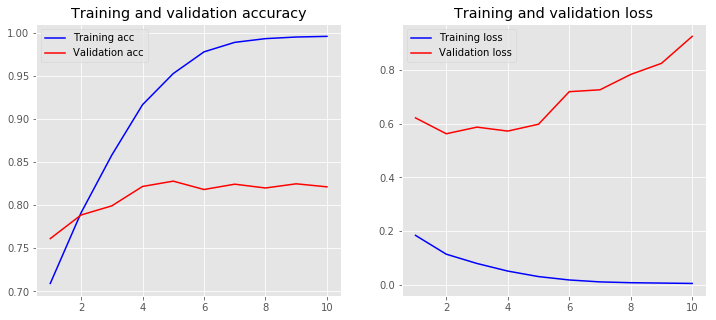

acc: 80.09%


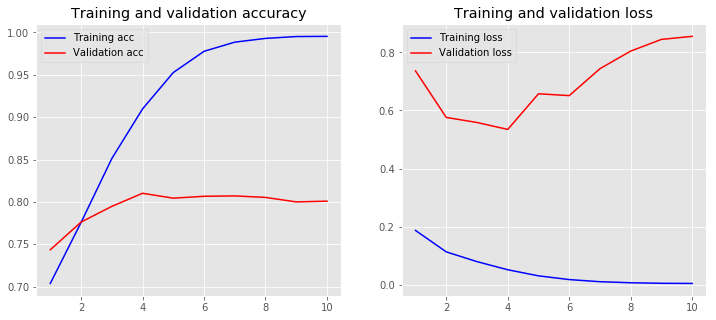

acc: 79.47%


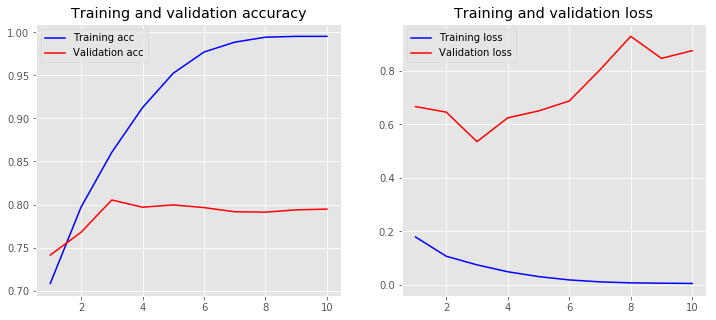

Training Accuracy (cross-validation): 80.15% 


In [180]:

# fix random seed for reproducibility
keras.backend.clear_session() 
seed = 42
np.random.seed(seed)
set_random_seed(2)


# define 5-fold cross validation test harness
# each iteration uses 4 folds of train data as the cross-validation train data and 1 fold as the cross validatioin test data.
# this gives the better picture of the real performance of the model as deep learing models are likely to be overfitted.
# the chart is run for each fold to see the sequential epoch performance and so that it may be adjusted in the successive code runs

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
cvscores = []
for train, test in kfold.split(X_train, y_train_1d):
    
    model = Sequential()
    model.add(layers.Embedding(len(vocab),
                     output_dim=embedding_dim,
                     #mask_zero=False,
                     weights=[(np.random.rand(nb_words, WV_DIM) - 0.5) / 5.0], # this is the only reference to w2vec
                     input_length=MAX_SEQUENCE_LENGTH,
                     trainable=True))
    model.add(layers.GlobalMaxPool1D())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(3, activation = (tf.nn.softmax)))
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# Fit the model
    history = model.fit(X_train[train], y_train_one_hot[train], 
                        epochs=10, 
                        batch_size=10, 
                        verbose=0, 
                        class_weight = class_weights, 
                        validation_data=(X_train[test], y_train_one_hot[test]))
# evaluate the model
    scores = model.evaluate(X_train[test], y_train_one_hot[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    plot_history(history)
    plt.show()
    cvscores.append(scores[1] * 100)
print("Training Accuracy (cross-validation): %.2f%% " % (np.mean(cvscores)))

Training Accuracy (non cross-validation): 0.9480
Testing Accuracy:  0.8081
             precision    recall  f1-score   support

          0       0.95      0.81      0.87      4430
          1       0.42      0.84      0.56       315
          2       0.57      0.80      0.66       835

avg / total       0.86      0.81      0.82      5580



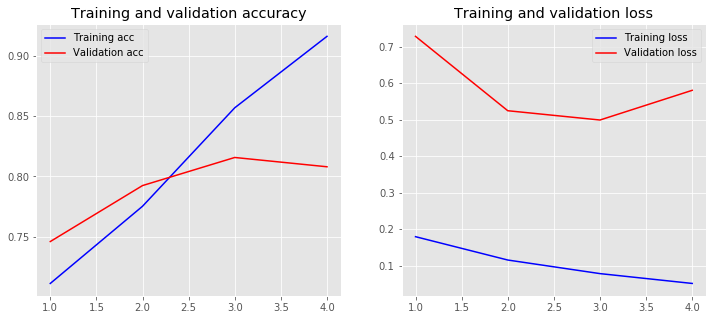

In [181]:
# fitting the model on the full train_data

keras.backend.clear_session() 
seed = 42
np.random.seed(seed)
set_random_seed(2)


model = Sequential()
model.add(layers.Embedding(len(vocab),
                     output_dim=embedding_dim,
                     #mask_zero=False,
                     weights=[(np.random.rand(nb_words, WV_DIM) - 0.5) / 5.0], # this is the only reference to w2vec
                     input_length=MAX_SEQUENCE_LENGTH,
                     trainable=True))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(3, activation = (tf.nn.softmax)))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train_one_hot, 
                        epochs=4, 
                        batch_size=10, 
                        verbose=0, 
                        class_weight = class_weights, 
                        validation_data=(X_test, y_test_one_hot))


loss, accuracy = model.evaluate(X_train, y_train_one_hot, verbose=False)
print("Training Accuracy (non cross-validation): {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test_one_hot, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

y_pred = model.predict_classes(X_test)
#print(metrics.accuracy_score(test_data.Annotation, y_pred))
print (classification_report(y_pred,test_data.Annotation))

plot_history(history)

## Deep Learning Model 2 (Keras implementation)

1. Layers: Sequential
2. FastText Embedding

In [182]:
keras.backend.clear_session() 
seed = 42
np.random.seed(seed)

set_random_seed(2)

# WV_DIM = 50

WV_DIM = 200
nb_words = len(vocab)
# we initialize the matrix with random numbers
wv_matrix = (np.random.rand(nb_words, WV_DIM) - 0.5) / 5.0
for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    try:
        embedding_vector = word_vectors[word]
        # words not found in embedding index will be all-zeros.
        wv_matrix[i] = embedding_vector
    except:
        pass    

acc: 80.49%


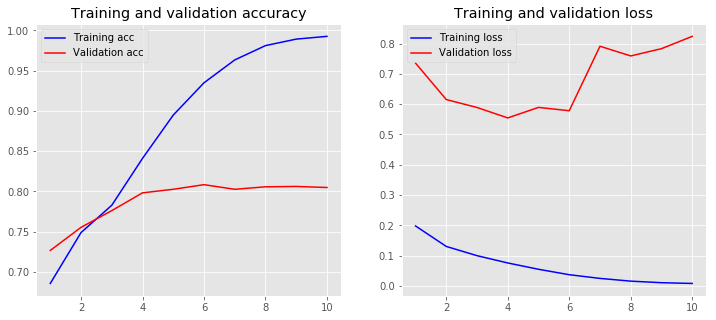

acc: 80.67%


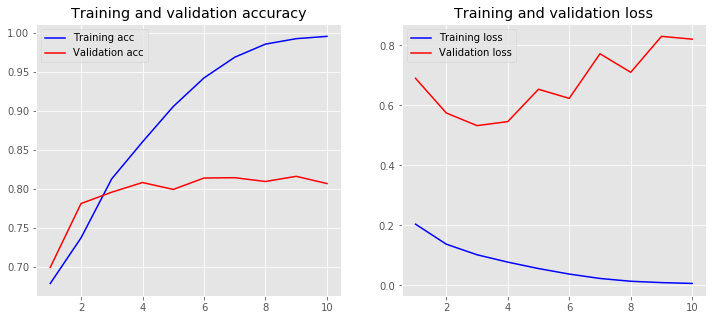

acc: 79.91%


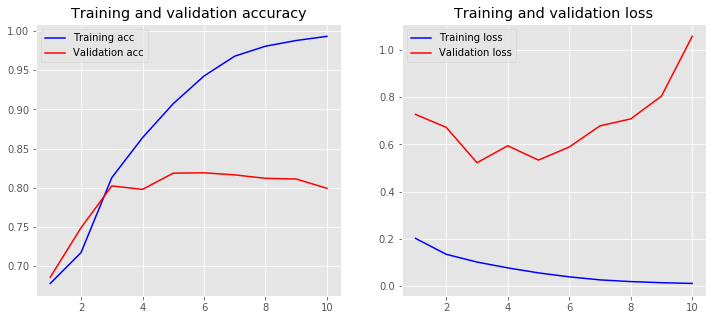

acc: 80.09%


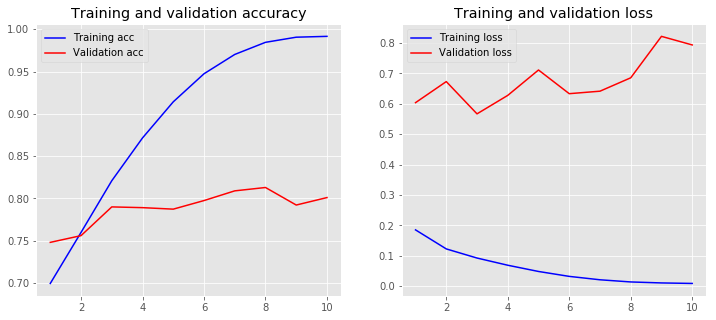

acc: 79.16%


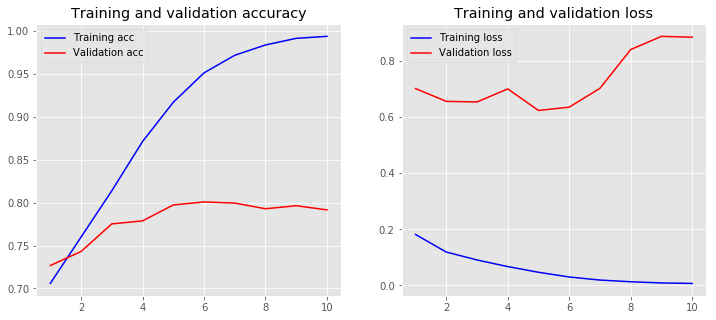

Training Accuracy (cross-validation): 80.07% 


In [183]:
# fix random seed for reproducibility
keras.backend.clear_session() 
seed = 42
np.random.seed(seed)
set_random_seed(2)


# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
cvscores = []
for train, test in kfold.split(X_train, y_train_1d):
    
    model = Sequential()
    model.add(layers.Embedding(len(vocab),
                         output_dim=embedding_dim,
                         #mask_zero=False,
                         weights=[wv_matrix], # this is the only reference to w2vec
                         input_length=MAX_SEQUENCE_LENGTH,
                         trainable=True))
    model.add(layers.GlobalMaxPool1D())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(3, activation = (tf.nn.softmax)))
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
# Fit the model
    history = model.fit(X_train[train], y_train_one_hot[train], 
                        epochs=10, 
                        batch_size=10, 
                        verbose=0, 
                        class_weight = class_weights, 
                        validation_data=(X_train[test], y_train_one_hot[test]))
# evaluate the model
    scores = model.evaluate(X_train[test], y_train_one_hot[test], verbose=0)
    
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    plot_history(history)
    plt.show()
    cvscores.append(scores[1] * 100)
print("Training Accuracy (cross-validation): %.2f%% " % (np.mean(cvscores)))

Training Accuracy (non cross-validation): 0.9808
Testing Accuracy:  0.8179
             precision    recall  f1-score   support

          0       0.90      0.85      0.87      4008
          1       0.66      0.79      0.72       529
          2       0.64      0.72      0.68      1043

avg / total       0.83      0.82      0.82      5580



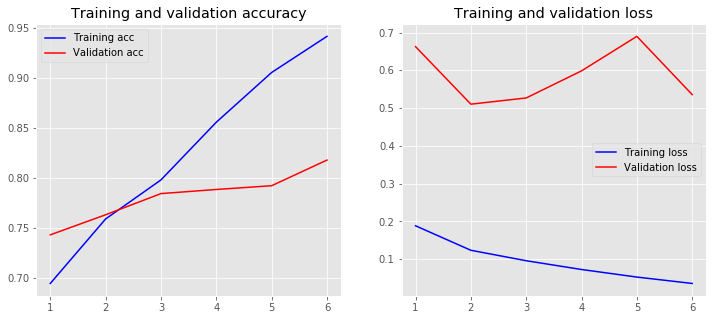

In [184]:
# fitting the model on the full train_data
keras.backend.clear_session() 
seed = 42
np.random.seed(seed)
set_random_seed(2)

model = Sequential()
model.add(layers.Embedding(len(vocab),
                         output_dim=embedding_dim,
                         #mask_zero=False,
                         weights=[wv_matrix], # this is the only reference to w2vec
                         input_length=MAX_SEQUENCE_LENGTH,
                         trainable=True))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(3, activation = (tf.nn.softmax)))
model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
# Fit the model
history = model.fit(X_train, y_train_one_hot, 
                        epochs=6, 
                        batch_size=10, 
                        verbose=0, 
                        class_weight = class_weights, 
                        validation_data=(X_test, y_test_one_hot))

loss, accuracy = model.evaluate(X_train, y_train_one_hot, verbose=False)
print("Training Accuracy (non cross-validation): {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test_one_hot, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

y_pred = model.predict_classes(X_test)
#print(metrics.accuracy_score(test_data.Annotation, y_pred))
print (classification_report(y_pred,test_data.Annotation))

plot_history(history)
